In [1]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np

import pywt

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

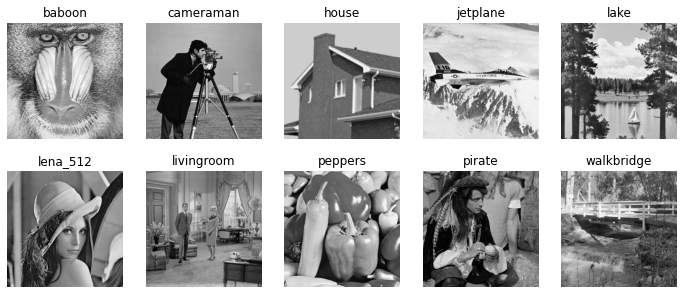

In [2]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [3]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])
dataset.shape

(10, 512, 512)

Анализ преобразования:
* Выполняем преобразование, получаем коэффициенты
* Перебираем значение порога $\delta$, для каждого $\delta$ считаем compress ratio
$$
CR = \frac{\#\{i \mid |x_i| > \delta\}}{x.size}
$$
(в статье 2014 года за авторством Харюка и Оселедеца определялось именно так)
* Все элементы, которые меньше $\delta$ по модулю, зануляем. Восстанавливаем обратным преобразованием картинку из сжатых коэффициентов.
* Считаем ошибку (в статье --- PSNR, но, наверное, можно и просто относительную ошибку в норме Фробениуса...)
* Для разных дельт у нас 2 массива --- значения CR и значения ошибки. Строим график ошибки от CR.

$\delta$ больше --- $CR$ падает, так как мы не нулями считаем меньше элементов. А ошибка, наоборот, растёт (зануляем больше).

Хотим: $CR$ поменьше и ошибку поменьше.

In [4]:
d = 9
n = 2 ** d
modes = [2] * d

wtt_classic = wrappers.WTTwrapper(1) #классика
wtt_rpca_1 = wrappers.WTTwrapper(2) #просто RPCA вместо SVD
wtt_rpca_2 = wrappers.WTTwrapper(3) #RPCA с сохранением sparse-частей

algs = [wtt_classic, wtt_rpca_1, wtt_rpca_2]

In [5]:
eps = 1e-5
ranks = [30] * (d - 1)

In [6]:
for w in algs:
    w.adjust(
        dataset[1],
        d,
        modes,
        ranks=ranks,
        eps=eps,
        is_2D=True
    )

Применяем фильтры к этой же фотографии:

In [10]:
deltas = np.logspace(-10, -1, 30)

CR = [[] for _ in range(len(algs))]
errors = [[] for _ in range(len(algs))]

coeffs = []
for w in algs:
    coeffs.append(w.apply(dataset[1], is_2D = True))

for delta in deltas:
    for i in range(len(algs)):
        ratio = np.sum(np.abs(coeffs[i]) > delta) / coeffs[i].size
        CR[i].append(ratio)
        
        #delta повышается, так что всё дальнейшее легально
        coeffs[i][np.abs(coeffs[i]) <= delta] = 0
        iwtt_res = algs[i].apply_inverse(coeffs[i], is_2D=True)
        error = np.linalg.norm(dataset[1] - iwtt_res) / np.linalg.norm(dataset[1])
        errors[i].append(error)

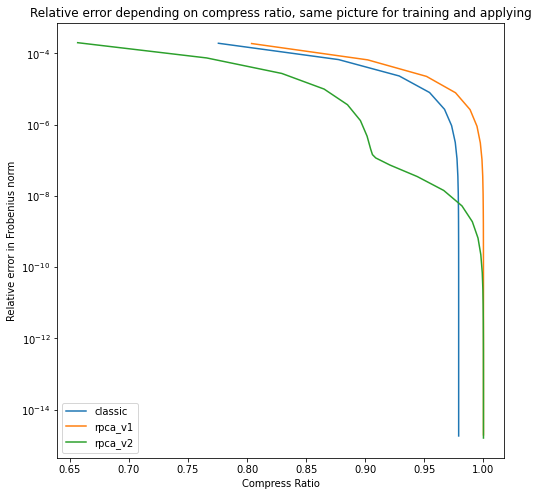

In [18]:
plt.figure(figsize=(8,8))
alg_names = ['classic', 'rpca_v1', 'rpca_v2']

for i in range(len(algs)):
    plt.plot(CR[i], errors[i], label=alg_names[i])
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Relative error in Frobenius norm')
plt.title('Relative error depending on compress ratio, same picture for training and applying')
plt.legend()
plt.show()

Попробуем теперь применить к другой картинке:

In [17]:
CR_2 = [[] for _ in range(len(algs))]
errors_2 = [[] for _ in range(len(algs))]

coeffs = []
for w in algs:
    coeffs.append(w.apply(dataset[2], is_2D = True))

for delta in deltas:
    for i in range(len(algs)):
        ratio = np.sum(np.abs(coeffs[i]) > delta) / coeffs[i].size
        CR_2[i].append(ratio)
        
        #delta повышается, так что всё дальнейшее легально
        coeffs[i][np.abs(coeffs[i]) <= delta] = 0
        iwtt_res = algs[i].apply_inverse(coeffs[i], is_2D=True)
        error = np.linalg.norm(dataset[2] - iwtt_res) / np.linalg.norm(dataset[2])
        errors_2[i].append(error)

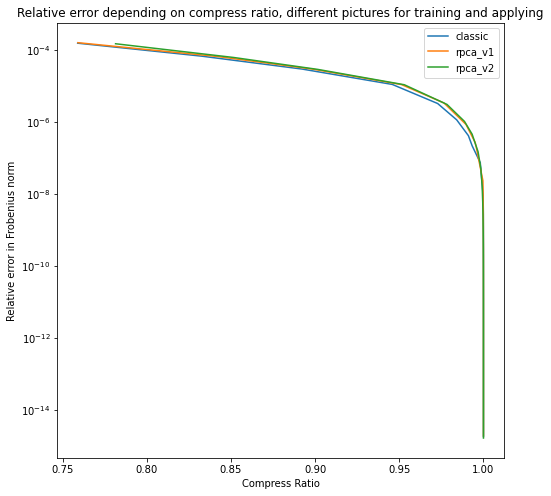

In [19]:
plt.figure(figsize=(8,8))
alg_names = ['classic', 'rpca_v1', 'rpca_v2']

for i in range(len(algs)):
    plt.plot(CR_2[i], errors_2[i], label=alg_names[i])
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Relative error in Frobenius norm')
plt.title('Relative error depending on compress ratio, different pictures for training and applying')
plt.legend()
plt.show()